The aim of this notebook is to visualize (img, label) example from FLARE2022 dataset.

# Imports & constants

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    EnsureTyped,
    ScaleIntensityRanged,
    Orientationd,
    Spacingd,
    RandCropByPosNegLabeld
)
from monai.data import Dataset, DataLoader
from monai.utils import first

In [2]:
DATA_DIR = '../data/finetune'

# Visualization

In [3]:
img_paths = sorted((Path(DATA_DIR)/Path('imgs')).glob('*.nii.gz'))
label_paths = sorted((Path(DATA_DIR)/Path('labels')).glob('*.nii.gz'))
data = [{'img': img_path, 'label': label_path} 
        for img_path, label_path in zip(img_paths, label_paths)]

In [4]:
transforms = Compose([
    LoadImaged(keys=['img', 'label']),
    EnsureChannelFirstd(keys=['img', 'label']),
    Orientationd(keys=['img', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['img'], a_min=-175, a_max=250,
                            b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['img', 'label'], source_key='img'),
    Spacingd(keys=['img', 'label'], pixdim=(1.5, 1.5, 2), 
                mode=('bilinear')),
    EnsureTyped(keys=['img', 'label'], device='cpu', track_meta=False),
    RandCropByPosNegLabeld(
        keys=['img', 'label'],
        label_key='label',
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=2,
        image_key='img',
        image_threshold=0,
    )
])

In [5]:
dataset = Dataset(data=data, transform=transforms)
sample = dataset[0]

In [6]:
sample

[{'img': tensor([[[[0.6256, 0.7083, 0.7195,  ..., 0.0000, 0.0000, 0.0000],
            [0.5503, 0.7169, 0.7654,  ..., 0.0000, 0.0000, 0.0000],
            [0.5293, 0.6575, 0.6945,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.2238, 0.2185, 0.1971,  ..., 0.0000, 0.0000, 0.0000],
            [0.1714, 0.1727, 0.1861,  ..., 0.0000, 0.0000, 0.0000],
            [0.1979, 0.2097, 0.2270,  ..., 0.0000, 0.0000, 0.0000]],
  
           [[0.8591, 0.7466, 0.5365,  ..., 0.0000, 0.0000, 0.0000],
            [0.6879, 0.6509, 0.5167,  ..., 0.0000, 0.0000, 0.0000],
            [0.4869, 0.5562, 0.5587,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.1944, 0.2037, 0.2152,  ..., 0.0000, 0.0000, 0.0000],
            [0.1707, 0.1943, 0.2067,  ..., 0.0000, 0.0000, 0.0000],
            [0.1990, 0.2292, 0.2416,  ..., 0.0000, 0.0000, 0.0000]],
  
           [[0.9515, 0.6546, 0.4026,  ..., 0.0000, 0.0000, 0.0000],
            [0.7865, 0.6235, 0.3951,  ..., 0.0000, 0.0000, 0.0000],

Note that when using `Dataset` only, a list of data dictionaries are returned 
(data isn't fully collated yet).

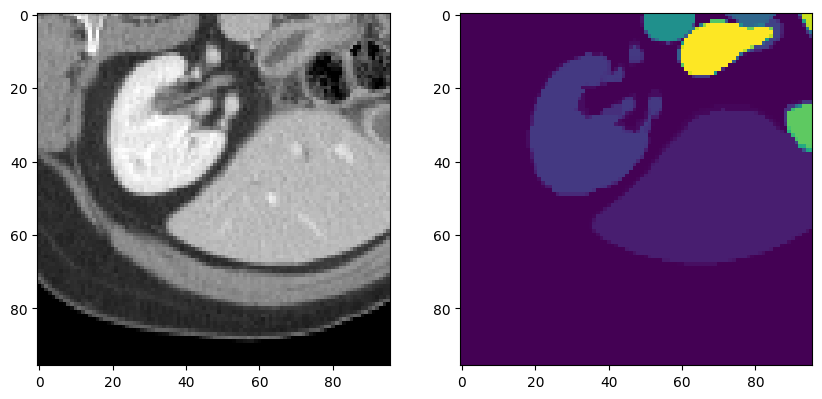

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(sample[1]['img'][0, :, :, 50], cmap='gray')
axs[1].imshow(sample[1]['label'][0, :, :, 50])
plt.show()

Let's see what happens when using `DataLoader`.

In [9]:
loader = DataLoader(dataset, shuffle=False)
data_dict = first(loader)
imgs = data_dict['img']
labels = data_dict['label']

In [10]:
imgs.shape, labels.shape

(torch.Size([2, 1, 96, 96, 96]), torch.Size([2, 1, 96, 96, 96]))

The data is now collated properly.

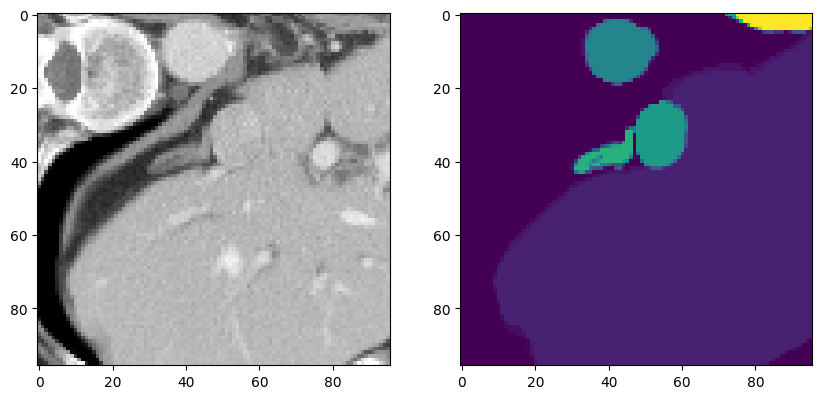

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(imgs[0, 0, :, :, 50], cmap='gray')
axs[1].imshow(labels[0, 0, :, :, 50])
plt.show()